In [148]:
import numpy as np
import pandas as pd
import random

import matplotlib
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, GridSearchCV

from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import (KFold, train_test_split, 
                                     GridSearchCV, RandomizedSearchCV)


from sklearn.preprocessing import StandardScaler

import seaborn as sns

In [149]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()


Обработка данных в train.csv

In [150]:
DATASET_PATH_1 = '../../Course/course2/train.csv'
train = pd.read_csv(DATASET_PATH_1)
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644



Избавление от NaN

In [151]:
len(train) - train.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [152]:
train.loc[train['Healthcare_1'].isnull(),'Healthcare_1'] = train['Healthcare_1'].median()
train.loc[train['LifeSquare'].isnull(),'LifeSquare'] = train['LifeSquare'].median()


Обработка выбросов

In [153]:
train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,36.266040,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,76.609981,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,25.527399,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [154]:
train.loc[train['Rooms'] == 0, 'Rooms'] = train['Rooms'].median()
train.loc[train['HouseYear'] >=2020, 'HouseYear'] = train['HouseYear'].median()
train.loc[train['HouseFloor'] == 0 ,'HouseFloor'] = train['HouseFloor'].median()
floor_outliers = train[train['Floor'] > train['HouseFloor']].index
train.loc[floor_outliers,'Floor'] = train.loc[floor_outliers, 'HouseFloor'].apply(lambda x :random.randint(1, x))


Привидение типов

In [155]:
train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear        float64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [156]:
train['Id'] = train['Id'].astype(str)
train['DistrictId'] = train['DistrictId'].astype(str)

train = pd.get_dummies(data=train,columns=['Ecology_2','Ecology_3', 'Shops_2'])

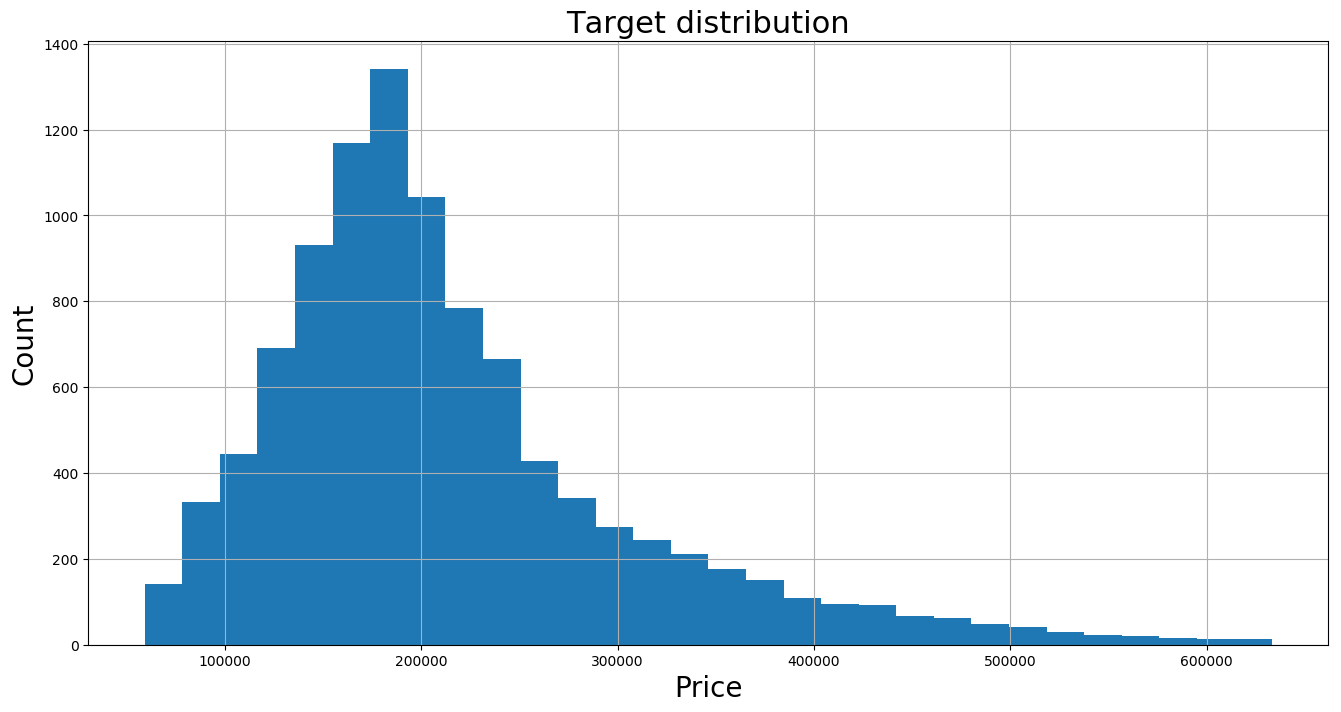

In [157]:
plt.figure(figsize = (16, 8),dpi =100 )

train['Price'].hist(bins=30)
plt.ylabel('Count',fontsize = 20)
plt.xlabel('Price',fontsize = 20)

plt.title('Target distribution',fontsize = 22)
plt.show()

Отбор признаков

In [158]:
train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

In [159]:
feature_names = ['Rooms','Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_B' ,'Ecology_3_B','Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_B','Shops_2_A']
target_name ='Price'



X = train[feature_names]
y = train[target_name]

X_train,X_test,y_train,y_test= train_test_split(X , y, test_size = 0.33,shuffle = True, random_state = 21)


Обучение модели

In [160]:
hyper_space = {'n_estimators': [1000, 1500, 2000, 2500],
               'max_depth':  [4, 5, 8, -1],
               'num_leaves': [15, 31, 63, 127],
               'subsample': [0.6, 0.7, 0.8, 1.0],
               'colsample_bytree': [0.6, 0.7, 0.8, 1.0]}



est = LGBMRegressor(boosting='gbdt', n_jobs=-1, random_state=2018)

In [ ]:
gs = GridSearchCV(est, hyper_space, scoring='r2', cv=4, verbose=1)
gs_results = gs.fit(X_train, y_train)

Fitting 4 folds for each of 1024 candidates, totalling 4096 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train R2:	0.902
Test R2:	0.731


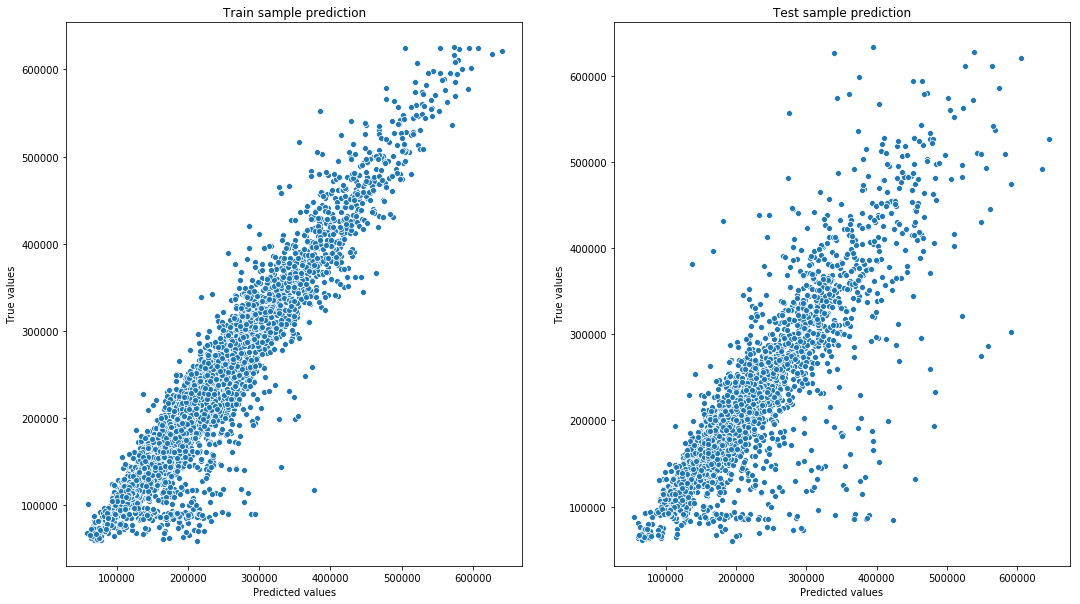

In [72]:
y_train_preds1=gs_results.predict(X_train)
y_test_preds1=gs_results.predict(X_test)
evaluate_preds(y_train,y_train_preds1,y_test,y_test_preds1)

Обработка test.csv

In [ ]:
DATASET_PATH_2 = '../../Course/course2/test.csv'

In [114]:
test = pd.read_csv(DATASET_PATH_2)

In [115]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [116]:
test.loc[test['LifeSquare'].isnull(),'LifeSquare'] = test['LifeSquare'].median()
test.loc[test['Healthcare_1'].isnull(),'Healthcare_1'] = test['Healthcare_1'].median()
test.loc[test['Rooms'] == 0,'Rooms'] = test['Rooms'].median()
test[test['HouseYear'] >= 2020]
test.loc[test['HouseFloor'] == 0 ,'HouseFloor'] = test['HouseFloor'].median()
floor_outliers1 = test[test['Floor'] > test['HouseFloor']].index
test.loc[floor_outliers1,'Floor'] = test.loc[floor_outliers1, 'HouseFloor'].apply(lambda x :random.randint(1, x))



In [117]:
test = pd.get_dummies(data=test,columns=['Ecology_2','Ecology_3', 'Shops_2'])

In [119]:
test_features_2 = ['Rooms','Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_B' ,'Ecology_3_B','Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_B','Shops_2_A']

target = 'Price'



In [122]:
test['Price'] = gs_results.predict(test[test_features_2])

In [123]:
test[['Id','Price']].to_csv('DKhramov_predictions.csv',index = None)